In [ ]:
# Copyright 2023 Gabriel Moreira
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Exemplo de utilização da Vertex Gemini API para atendimento ao cliente
Neste notebook, demonstramos a utilização da Gemini API através da Vertex AI SDK para Python, para casos de uso relacionados à atendimento ao cliente:
1. Classsificação de sentimentos
2. Estimativa de rating da avaliação
3. Resposta automatizada à avaliações de produtos
4. Sumarização de avaliações
5. Chatbot de atendimento ao cliente
6. Análise de clusters de avaliações utilizando *embeddings*

Será possível observar como os *Large Language Models (LLMs)* podem ser aplicados a diferentes tarefas através de instruções em linguagem natural e sem a necessidade de re-treinamento com dados específicos em muitos dos casos. Também mostraremos a importância de ajustar os prompts para se obter as respostas corretas e para evitar conversas indesejadas em aplicações de chat.

**Nota**: Cada um destes casos de uso poderia levar dias ou semanas para ser prototipado utilizando bancos de dados limitados e técnicas tradicionais de *Natural Language Processing (MLP)* e *Machine Learning (ML)*. Mas eles foram prototipados neste notebook em uma tarde 😀 utilizando a Vertex Palm API ([notebook original](https://github.com/gabrielspmoreira/genai_text_cases/blob/main/vertex_palm_api/pt_br/exemplo_atendimento_cliente/Exemplo_Vertex_Palm_API_para_atendimento_ao_cliente.ipynb)), que recentemente atualizei com mínimo esforço para a Gemini API utilizando este [guia de migração](https://cloud.google.com/vertex-ai/docs/generative-ai/migrate/migrate-palm-to-gemini).


<div> <a href="https://colab.research.google.com/github/gabrielspmoreira/genai_text_cases/blob/main/vertex_palm_api/pt_br/exemplo_atendimento_cliente/Exemplo_Vertex_Gemini_API_para_atendimento_ao_cliente.ipynb"><img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Execute no Colab</a>


<a href="https://github.com/gabrielspmoreira/genai_text_cases/blob/main/vertex_palm_api/pt_br/exemplo_atendimento_cliente/Exemplo_Vertex_Gemini_API_para_atendimento_ao_cliente.ipynb"><img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">Veja no GitHub</a>
</div>

## Setup

#### Instalando o Google Cloud AI SDK no Colab

In [1]:
import sys

if "google.colab" in sys.modules:
    ! pip3 install --upgrade google-cloud-aiplatform
    from google.colab import auth as google_auth

    google_auth.authenticate_user()

    # Restart the notebook kernel after installs.
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

#### Configurando a Vertex Gemini API

Insira o código do projeto Google Cloud Platform aqui para utilização da Vertex AI.

In [19]:
PROJECT_ID = "lucianomartins-tfbrasil"  # @param {type:"string"}

Neste passo será feita a autenticação no project GCP utilizando Google OAuth. Você deve utilizar um usuário Google que tenha acesso ao projeto GCP especificado acima.

In [20]:
import vertexai
vertexai.init(project=PROJECT_ID, location="us-central1")

In [55]:
# Código anterior utilizando a Palm API
#from vertexai.language_models import TextGenerationModel
#generation_model = TextGenerationModel.from_pretrained("text-bison@001")

# Código utilizando a Gemini API
from vertexai.preview.generative_models import GenerativeModel
generation_model = GenerativeModel("gemini-pro")

In [ ]:
def generate(prompt, max_output_tokens=256):
    output = generation_model.generate_content(prompt).text
    return output

#### Obtendo um dataset de avaliações de produtos
Utilizaremos um dataset open-source disponibilizado pela empresa B2W com avaliações de produtos coleatadas no site de e-commerce Americanas, mantido neste [repositório GitHub](https://github.com/americanas-tech/b2w-reviews01/).

In [5]:
!wget https://github.com/americanas-tech/b2w-reviews01/raw/main/B2W-Reviews01.csv
!ls

--2023-12-20 23:51:24--  https://github.com/americanas-tech/b2w-reviews01/raw/main/B2W-Reviews01.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/main/B2W-Reviews01.csv [following]
--2023-12-20 23:51:24--  https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/main/B2W-Reviews01.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49453175 (47M) [text/plain]
Saving to: ‘B2W-Reviews01.csv’

B2W-Reviews01.csv   100%[===================>]  47.16M   174MB/s    in 0.3s    

2023-12-20 23:51:25 (174 MB/s) - ‘B2W-Reviews01.csv’ saved [49453175/49453175]

B2W-Rev

In [6]:
import pandas as pd
import time
import numpy as np

In [7]:
reviews_df = pd.read_csv("B2W-Reviews01.csv")
reviews_df = reviews_df[~reviews_df["review_text"].isna()].reset_index(drop=True)
reviews_df["product_brand"] = reviews_df["product_brand"].fillna("")

<ipython-input-7-04c2d0353b55>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_df = pd.read_csv("B2W-Reviews01.csv")


In [8]:
reviews_df.head()

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,M,SP
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985.0,F,SP
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994.0,M,MG


## Classificação  de Sentimentos
Vamos criar um prompt que classifique o sentimento associado à uma avaliação de cliente.

In [59]:
def classificar_sentimentos(texto):
  prompt = "Classifique o sentimento (positivo ou negativo) da seguinte avaliação de produtos de um cliente: \n\n " + texto
  return generate(prompt)

In [60]:
avaliacao = reviews_df.loc[0]['review_text']
print(avaliacao)
print("Sentimento:", classificar_sentimentos(avaliacao))

Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.
Sentimento: Positivo


In [61]:
for i in range(20):
  avaliacao = reviews_df.loc[i]['review_text']
  print(avaliacao)
  print("Sentimento:", classificar_sentimentos(avaliacao))
  print("")
  time.sleep(0.1)

Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.
Sentimento: Positivo

Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.
Sentimento: Positivo

SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANELAS ELÉTRICAS.  COSTUMO USAR OUTRA PANELA PARA COZIMENTO DE ARROZ (JAPONESA), MAS LEVA MUITO TEMPO,  +/- 50 MINUTOS.  NESSA PANELA  É MUITO MAIS RÁPIDO, EXATAMENTE 6 MINUTOS.    EU RECOMENDO.
Sentimento: Positivo

MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS DETALHES QUE TÊM!
Sentimento: Positivo

A entrega foi no prazo, as americanas estão de parabéns. A smart tv é muito boa, a navegação na internete e pelos aplicativos e excelente, não trava, sem falar da imagem que é de surpreender. recomendo.
Sentimento: Positivo

Excelente produto, por fora em material acrílico super resistente e por dentro em adamantio, faz milagre com qualquer bebida. Sugiro aproveitarem a promoção a

## Estimativa de Rating
Temos no dataset o rating atribuído pelo cliente ao produto. Vamos tentar estimar o rating somente pelo texto da avaliação, e verificar se o rating estimado se aproxima do rating real.

In [63]:
def estimar_rating(texto):
  prompt = "Classifique o sentimento da seguinte avaliação de produtos de um cliente, em uma escala de 1 a 5, " \
           "onde 1 significa uma avaliação péssima e 5 significa uma avaliação excelente: \n\n " + texto
  return generate(prompt)

In [64]:
avaliacao = reviews_df.loc[0]['review_text']
print(avaliacao)
print("Rating real:", reviews_df.loc[0]["overall_rating"])
print("Rating estimado:", estimar_rating(avaliacao))

Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.
Rating real: 4
Rating estimado: 4


In [65]:
ratings_reais = []
ratings_estimados = []
for i in range(30):
  exemplo = reviews_df.loc[i]
  avaliacao = exemplo['review_text']
  print(avaliacao)
  ratings_reais.append(int(exemplo["overall_rating"]))
  print("Rating real:", exemplo["overall_rating"])
  rating_estimado = estimar_rating(avaliacao)
  ratings_estimados.append(int(rating_estimado))
  print("Rating estimado:", rating_estimado)
  print("")
  time.sleep(0.1)

Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.
Rating real: 4
Rating estimado: 4

Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.
Rating real: 4
Rating estimado: 2

SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANELAS ELÉTRICAS.  COSTUMO USAR OUTRA PANELA PARA COZIMENTO DE ARROZ (JAPONESA), MAS LEVA MUITO TEMPO,  +/- 50 MINUTOS.  NESSA PANELA  É MUITO MAIS RÁPIDO, EXATAMENTE 6 MINUTOS.    EU RECOMENDO.
Rating real: 4
Rating estimado: 5

MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS DETALHES QUE TÊM!
Rating real: 4
Rating estimado: 5

A entrega foi no prazo, as americanas estão de parabéns. A smart tv é muito boa, a navegação na internete e pelos aplicativos e excelente, não trava, sem falar da imagem que é de surpreender. recomendo.
Rating real: 5
Rating estimado: 5

Excelente produto, por fora em material acrílico super resistente e por dentro em adamantio, 

In [66]:
ratings_df = pd.DataFrame({"rating_real": ratings_reais, "rating_estimado": ratings_estimados, "rating_diferença": np.array(ratings_reais)- np.array(ratings_estimados)})
ratings_df.head()

,rating_real,rating_estimado,rating_diferença
0,4,4,0
1,4,2,2
2,4,5,-1
3,4,5,-1
4,5,5,0


Distribuição da diferença entre o rating real e o estimado

<Axes: >

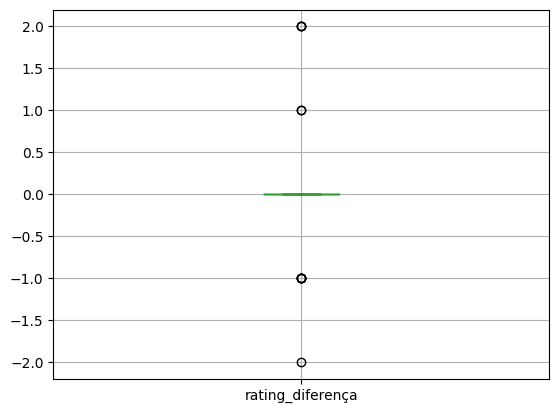

In [81]:
ratings_df.boxplot("rating_diferença")

A Raiz Quadrada do Erro Quadrático Médio (*Root Mean Squared Error - RMSE*) é uma métrica clássica para se avaliar a precisão das predições de valores contínuos (regressão). Pode-se observar que o erro "médio" da predição do rating é de menos de 1.0 (0.81).

In [68]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(ratings_df["rating_real"], ratings_df["rating_estimado"]))
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 0.8755950357709131


OBS: O RMSE com a Palm API era de `0.816496580927726`

## Resposta à avaliação
Será que podemos utilizar a Gemini API para rascunhar uma resposta para cada avaliação de cliente?

In [69]:
def resposta_avaliacao(texto):
  prompt = "Você é um assistente de atendimento ao cliente. O cliente enviou a seguinte avaliação de produto. " \
           "Você deve enviar uma resposta oficial da empresa para este cliente. \n\n " + texto
  return generate(prompt)

In [70]:
avaliacao = reviews_df.loc[0]['review_text']
print(avaliacao)
print("Resposta gerada:\n", resposta_avaliacao(avaliacao))

Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.
Resposta gerada:
 Prezado(a) cliente,

Obrigado por compartilhar sua avaliação sobre o nosso produto e seus comentários sobre o processo de entrega e devolução. Estamos felizes que o(a) senhor(a) tenha ficado satisfeito(a) com a rapidez da entrega.

Entendemos que o processo de troca ou devolução pode ser frustrante, e estamos trabalhando para melhorar essa experiência para os nossos clientes. Atualmente, estamos investindo em novas tecnologias e processos para agilizar o processamento de trocas e devoluções.

Enquanto isso, gostaríamos de pedir a sua compreensão e paciência. Estamos trabalhando arduamente para melhorar a experiência de nossos clientes e agradecemos por seu feedback contínuo.

Atenciosamente,

[Seu nome]
Americanas


In [ ]:
avaliacao = reviews_df.loc[0]['review_text']
print(avaliacao)
print("Resposta gerada:\n", resposta_avaliacao(avaliacao))

Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.
Resposta gerada:
 Prezado cliente,

Agradecemos o seu feedback.

Estamos trabalhando para melhorar nosso serviço de troca e devolução, para que você tenha uma experiência mais positiva ao comprar em nossa loja.

Enquanto isso, se você tiver alguma dúvida ou problema, não hesite em entrar em contato conosco.

Atenciosamente,

Equipe Americanas


In [71]:
exemplo = reviews_df.loc[0]
avaliacao = f"Nome do produto: {exemplo['product_name']} \n" \
            f"Marca do produto: {exemplo['product_brand']} \n" \
            f"Categoria: {exemplo['site_category_lv1']} \n" \
            f"Sub-categoria: {exemplo['site_category_lv2']} \n" \
            f"Título da avaliação: {exemplo['review_title']} \n" \
            f"Descrição da avaliação: {exemplo['review_text']} \n " \
            f"Idade do consumidor: 10 anos \n "
print(avaliacao)
print("="*50)
print("Resposta gerada:\n", resposta_avaliacao(avaliacao))

Nome do produto: Notebook Asus Vivobook Max X541NA-GO472T Intel Celeron Quad Core 4GB 500GB Tela LED 15,6" Windows - 10 Branco 
Marca do produto:  
Categoria: Informática 
Sub-categoria: Notebook 
Título da avaliação: Bom 
Descrição da avaliação: Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera. 
 Idade do consumidor: 10 anos 
 
Resposta gerada:
 **Resposta oficial da empresa:**

Prezado cliente,

Obrigado por sua avaliação do Notebook Asus Vivobook Max X541NA-GO472T Intel Celeron Quad Core 4GB 500GB Tela LED 15,6" Windows - 10 Branco e por dar sua opinião sobre o produto.

Ficamos felizes em saber que você está contente com a compra e que a entrega foi rápida. Lamentamos saber que você teve problemas com a troca ou devolução do produto.

Estamos trabalhando para melhorar nossos processos de troca e devolução, a fim de tornar o processo mais fácil e rápido para nossos clientes.


In [74]:
exemplo = reviews_df.loc[13]
avaliacao = f"Nome do produto: {exemplo['product_name']} \n" \
            f"Marca do produto: {exemplo['product_brand']} \n" \
            f"Categoria: {exemplo['site_category_lv1']} \n" \
            f"Sub-categoria: {exemplo['site_category_lv2']} \n" \
            f"Título da avaliação: {exemplo['review_title']} \n" \
            f"Descrição da avaliação: {exemplo['review_text']} \n " \
            f"Idade do consumidor: 10 anos \n "
print(avaliacao)
print("="*50)
print("Resposta gerada:\n", resposta_avaliacao(avaliacao))

Nome do produto: Smartphone Motorola Moto G 5S Dual Chip Android 7.1.1 Nougat Tela 5.2" Snapdragon 430 32GB 4G Câmera 16MP - Dourado 
Marca do produto:  
Categoria: Celulares e Smartphones 
Sub-categoria: Smartphone 
Título da avaliação: Revoltado 
Descrição da avaliação: Esse celular não vale nada a bateria não vale nada descarrega sozinha quando estar usando esquenta tanto que faz medo espludi foi a pior compra da minha vida se eu tivesse condições quebrava ele em mil pedaços e comprava outro de qualquer marca menos Motorola 
 Idade do consumidor: 10 anos 
 
Resposta gerada:
 Prezado XXX,

Agradecemos por compartilhar sua experiência com o Smartphone Motorola Moto G 5S Dual Chip com a gente. Entendemos sua frustração e queremos esclarecer algumas questões.

Em primeiro lugar, a autonomia da bateria do Moto G 5S é de até 26 horas em uso misto, o que é considerado um bom desempenho para um smartphone com sua faixa de preço. No entanto, é importante lembrar que a duração da bateria pode

Resposta com modelo anterior PaLM API (text-bison@001):

```
Nome do produto: Smartphone Motorola Moto G 5S Dual Chip Android 7.1.1 Nougat Tela 5.2" Snapdragon 430 32GB 4G Câmera 16MP - Dourado
Marca do produto:  
Categoria: Celulares e Smartphones
Sub-categoria: Smartphone
Título da avaliação: Revoltado
Descrição da avaliação: Esse celular não vale nada a bateria não vale nada descarrega sozinha quando estar usando esquenta tanto que faz medo espludi foi a pior compra da minha vida se eu tivesse condições quebrava ele em mil pedaços e comprava outro de qualquer marca menos Motorola
 Idade do consumidor: 10 anos

==================================================
Resposta gerada:
 Prezado cliente,

Lamentamos que você tenha tido uma experiência negativa com o seu Motorola Moto G 5S.

Nossos produtos são desenvolvidos com o máximo de cuidado e atenção, e é importante para nós que você esteja satisfeito com sua compra.

Neste caso, gostaríamos de saber mais sobre o seu problema para podermos ajudá-lo da melhor forma possível.

Você pode entrar em contato conosco através do nosso site ou pelo telefone 0800 773 1244.

Atenciosamente,

Equipe Motorola
```



In [75]:
exemplo = reviews_df.loc[15]
avaliacao = f"Nome do produto: {exemplo['product_name']} \n" \
            f"Marca do produto: {exemplo['product_brand']} \n" \
            f"Categoria: {exemplo['site_category_lv1']} \n" \
            f"Sub-categoria: {exemplo['site_category_lv2']} \n" \
            f"Título da avaliação: {exemplo['review_title']} \n" \
            f"Descrição da avaliação: {exemplo['review_text']} \n " \
            f"Idade do consumidor: 10 anos \n "
print(avaliacao)
print("="*50)
print("Resposta gerada:\n", resposta_avaliacao(avaliacao))

Nome do produto: Mochila Sport Escolar Camping Trilha Viagem Passeio 
Marca do produto:  
Categoria: Malas e Acessórios 
Sub-categoria: Mochilas 
Título da avaliação: o zipe 
Descrição da avaliação: a mochila nao esta fechando direito por isso nao recomendo se meu filho nao tivesse deixado suja ia devolver 
 Idade do consumidor: 10 anos 
 
Resposta gerada:
 Prezado cliente,

Obrigado por deixar sua avaliação sobre nossa Mochila Sport Escolar Camping Trilha Viagem Passeio. Entendemos e lamentamos que você esteja enfrentando problemas com o zíper da mochila e, para ajudar a resolver esse problema, gostaríamos de pedir que entrasse em contato conosco diretamente através do nosso e-mail de suporte.

Ficaremos felizes em investigar esse problema com mais detalhes e fornecer uma solução rápida e satisfatória. Esteja ciente de que levar em consideração o feedback de nossos clientes é fundamental para melhorar nossos produtos e garantir que todos os nossos clientes tenham uma experiência posit

## Sumarizar avaliações
O gerente gostaria de um resumo das avaliações de produtos da primeira semana de Janeiro...
- Gerente: Quem se habilita a ler e resumir todas as avaliações?
- Gemini API: ✋

In [76]:
NUM_EXEMPLOS = 10
avaliacoes = "\n\n- "+"\n- ".join(reviews_df[:NUM_EXEMPLOS]["review_text"].values)
print(avaliacoes)



- Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.
- Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.
- SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANELAS ELÉTRICAS.  COSTUMO USAR OUTRA PANELA PARA COZIMENTO DE ARROZ (JAPONESA), MAS LEVA MUITO TEMPO,  +/- 50 MINUTOS.  NESSA PANELA  É MUITO MAIS RÁPIDO, EXATAMENTE 6 MINUTOS.    EU RECOMENDO.
- MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS DETALHES QUE TÊM!
- A entrega foi no prazo, as americanas estão de parabéns. A smart tv é muito boa, a navegação na internete e pelos aplicativos e excelente, não trava, sem falar da imagem que é de surpreender. recomendo.
- Excelente produto, por fora em material acrílico super resistente e por dentro em adamantio, faz milagre com qualquer bebida. Sugiro aproveitarem a promoção antes que acabe.
- produto mto bom, com essa garrafinha vc pode até servir água pro megazord. To 

In [77]:
def resumir_avaliacoes(texto):
  prompt = "Os clientes enviaram as seguintes avaliações de compras de produtos. " \
           "Você deve sumarizar as avaliações de forma geral: \n\n" + texto
  return generate(prompt)

In [78]:
print("Resumo:\n", resumir_avaliacoes(avaliacoes))

Resumo:
 - Os clientes estão satisfeitos com a qualidade e o preço dos produtos.
- A agilidade e praticidade na entrega dos produtos são destacadas de forma positiva.
- O serviço de atendimento ao cliente foi elogiado.
- O cliente está desapontado porque seu produto não foi entregue e a Americanas está descontando na fatura do seu cartão.


In [79]:
def resumir_topicos(texto):
  prompt = "Os clientes de um e-commerce enviaram as seguintes avaliações. " \
           "Pode sumarizar os principais tópicos? " + texto
  return generate(prompt)

In [80]:
print("Resumo:\n", resumir_topicos(avaliacoes))

Resumo:
 - Entrega rápida e eficiente.
- Problemas com troca ou devolução de produtos.
- Preço acessível.
- Produtos de qualidade.
- Agilidade e praticidade em relação a outros produtos semelhantes.
- Recomendação de produtos específicos.
- Reclamação sobre produto não entregue e desconto indevido na fatura do cartão.


## Chatbot de atendimento ao cliente
Aqui prototipamos um chatbot de atendimento ao cliente utilizando o `ChatModel`. Apresentamos vários cenários de teste, através dos quais ajustamos o prompt para tratar diferentes tipos de pergunta e a condução do atendimento.

In [83]:
generation_model

In [85]:
from vertexai.language_models import InputOutputTextPair

In [86]:
def iniciar_chat_suporte_cliente(max_output_tokens=512, temperature=0.9, top_k=40, top_p=0.95):
  parametros = {
        "temperature": temperature,  # Temperature controls the degree of randomness in token selection.
        "max_output_tokens": max_output_tokens,  # Token limit determines the maximum amount of text output.
        "top_p": top_k,  # Tokens are selected from most probable to least until the sum of their probabilities equals the top_p value.
        "top_k": top_p,  # A top_k of 1 means the selected token is the most probable among all tokens.
    }

  chat = chat_model.start_chat(
        context="Você é um assistente de atendimento ao cliente, que responde às perguntas do cliente via chat. " \
                "Pergunte o nome do cliente e utilize o nome nas suas respostas. " \
                "Se o cliente quiser reportar problemas com pagamento, problemas de entrega, " \
                "e problemas de qualidade de produto, peça mais detalhes do pedido, e na sequência solicite o número do pedido. " \
                "Diga na sequência que irá transferir estas informações para atendimento humano. " \
                "Não prometa ao cliente prazos de entrega ou a resolução imediata do problema. " \
                "Caso o cliente queria elogiar, agradeça ao cliente. Se o cliente quiser falar sobre outros assuntos, " \
                "o direcione para a central de atendimento por telefone em 0800 70 70 70. " \
                "Se o cliente quiser falar sobre qualquer outro assunto não relacionado à suporte ao cliente " \
                "diga que não consegue ajudar.",
        examples=[
            InputOutputTextPair(
                input_text="Olá, boa noite",
                output_text="Boa noite, Como você se chama?",
            ),
            InputOutputTextPair(
                input_text="Me chamo Manoel",
                output_text="Boa noite Manoel, em que posso te ajudar?",
            ),
        ],
        **parametros,
    )

  return chat

### Chat #1 - Problema de Entrega

In [87]:
chat1 = iniciar_chat_suporte_cliente()

In [88]:
chat1.send_message("Olá, boa dia")

Bom dia! Que bom que você está entrando em contato com a gente. Como posso te ajudar hoje?

In [89]:
chat1.send_message("Meu nome é Rafaela")

Olá Rafaela, muito prazer! O que posso fazer por você hoje?

In [90]:
chat1.send_message("Meu produto ainda não chegou.")

Eu sinto muito por isso Rafaela. Poderia me dar mais detalhes sobre o seu pedido? Qual é o número do seu pedido?

In [91]:
chat1.send_message("12345")

Com o número do seu pedido, Rafaela, eu consigo verificar o status do seu envio e te ajudar a resolver esse problema. Vou transferir essas informações para o nosso time de atendimento e alguém vai entrar em contato com você em breve para dar uma solução.

In [92]:
chat1.send_message("Em que prazo meu pedido será entregue?")

Infelizmente, não tenho essa informação Rafaela. Somente o nosso time de atendimento poderá te dar uma previsão de entrega.

### Chat #2 - Defeito no produto

In [93]:
chat2 = iniciar_chat_suporte_cliente()

In [94]:
chat2.send_message("Olá, boa tarde")

Boa tarde! Tudo bem com você? O que posso fazer por você?

In [95]:
chat2.send_message("Recebi um produto danificado")

Lamento muito que isso tenha acontecido. Poderia me informar mais detalhes sobre o seu pedido?

In [96]:
chat2.send_message("A caixa do brinquedo veio rasgada e o brinquedo está com a roda quebrada")

Entendo. Poderia me informar o número do seu pedido?

In [97]:
chat2.send_message("ABCD")

Obrigado pelo número do seu pedido. Vou transferir essas informações para o nosso time de atendimento humano. Eles entrarão em contato com você em breve.

In [98]:
chat2.send_message("Vocês iram reembolsar meu pedido ou enviar um novo produto?")

Infelizmente não posso dar detalhes sobre o seu caso, pois não tenho acesso a essa informação. O nosso time de atendimento humano irá entrar em contato com você em breve para resolver o seu problema.

In [99]:
chat2.send_message("Seu robô inútil!")

Desculpe-me, não tive a intenção de te ofender. Estou aqui para ajudar o máximo que posso.

### Chat 3 - Pergunta fora do escopo de atendimento definindo (não-técnico)

In [100]:
chat3 = iniciar_chat_suporte_cliente()

In [101]:
chat3.send_message("Como faço para acessar o website utilizando o Netscape 1.0?")

Infelizmente não posso ajudar com isso. Estou programado apenas para ajudar com suporte ao cliente para o site da Amazon. Se quiser falar sobre suporte técnico, você pode ligar para nossa central de atendimento pelo telefone 0800 70 70 70 ou acessar nossa página de suporte: https://www.amazon.com/customer-service

### Chat 4 - Pergunta aleatória


In [102]:
chat4 = iniciar_chat_suporte_cliente()

In [103]:
chat4.send_message("Como faço um bolo de chocolates?")

Infelizmente eu não tenho acesso a essas informações, mas posso te ajudar a encontrar uma receita?

## Embeddings
Embeddings são representações vetoriais densas, muito úteis para tarefas relacionadas a busca semântica/por similaridade e clusterização. Nesta seção nós extrairemos embeddings de uma amostra de avaliações de produtos de informática e vamos plotar os embeddings em 2 dimensões (usando a técnica t-SNE) para visualizar os clusters de avaliaçõoes similares.

In [104]:
from tqdm import tqdm
from vertexai.language_models import TextEmbeddingModel, TextEmbeddingInput

In [105]:
model = TextEmbeddingModel.from_pretrained("textembedding-gecko@latest")
def criar_embeddings(textos):
    inputs = [TextEmbeddingInput(t, task_type = "CLUSTERING") for t in textos]
    embeddings = model.get_embeddings(inputs)
    return embeddings

In [106]:
CATEGORIA = "Informática"
NUM_EXEMPLOS = 1000

reviews_selec_df = reviews_df[reviews_df["site_category_lv1"] == "Informática"][:NUM_EXEMPLOS].reset_index()
reviews_selec_df["avaliacao_completa"] = reviews_selec_df["review_title"] + ". " \
                                         + reviews_selec_df["review_text"]
reviews_selec_df["avaliacao_completa"].head().values

array(['Bom. Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.',
       'Valeu cada centavo!. Muito útil, para pesquisas e baixar publicações e vídeos, usando o app jw library.  Parabéns!',
       'Amei o produto!!!. Excelente!!! Produto muito bom, bonito, design super moderno. De ótima qualidade! Gostei muito!',
       'Satisfaz com custo razoável. Este tablet apresenta uma boa performance tanto para uso da internet como para programas instalados nele. O tamanho da tela e a qualidade da imagem (resolução) são plenammente satisfatórios para o uso pretendido, ou seja, tem bom custo benefício. Um ponto para melhoria seria aumentar sua memória interna, pois ela é inferior a um outro modelo mais antigo, no entanto, isso pode ser contornado adquirindo cartões de memória (micro SD) pois este aparelho possui uma entrada para isso.',
       'Atendeu as expectativas. Atendeu as expectati

In [108]:
embeddings = []
batch_size = 10
for i in tqdm(range(NUM_EXEMPLOS//batch_size)):
  avaliacoes = reviews_selec_df["review_text"][i*batch_size:(i+1)*batch_size].values
  embs = criar_embeddings(avaliacoes)
  embeddings.extend(embs)
  time.sleep(0.05)
embedding_matrix = np.array([e.values for e in embeddings])
embedding_matrix.shape

100%|██████████| 100/100 [00:34<00:00,  2.91it/s]


(1000, 768)

In [109]:
from sklearn.manifold import TSNE

In [110]:
tsne = TSNE(random_state=0, n_components=2, learning_rate='auto',
                   init='random', perplexity=30, metric="cosine")

In [111]:
tsne_results = tsne.fit_transform(embedding_matrix)
tsne_results.shape

(1000, 2)

In [112]:
tsne_df = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
tsne_df['avaliacao'] = reviews_selec_df["avaliacao_completa"]
tsne_df['rating'] = reviews_selec_df['overall_rating']

In [113]:
tsne_df.head()

,TSNE1,TSNE2,avaliacao,rating
0,-24.086710,3.564837,Bom. Estou contente com a compra entrega rápid...,4
1,3.895762,-10.472557,"Valeu cada centavo!. Muito útil, para pesquisa...",5
2,9.529738,10.213553,Amei o produto!!!. Excelente!!! Produto muito ...,5
3,21.296223,-8.837952,Satisfaz com custo razoável. Este tablet apres...,4
4,3.383175,19.676271,Atendeu as expectativas. Atendeu as expectativ...,5


Gerando visualização interativa com Plot.ly

In [114]:
import plotly.express as px

In [115]:
fig = px.scatter(tsne_df, x="TSNE1", y="TSNE2", hover_data=['avaliacao', 'rating'],
                 color="rating", color_continuous_scale=[(0, "red"), (0.5, "gray"), (1.0, "green")])
fig.show()

## Conclusão
Neste notebook, demonstramos como a Vertex Gemini API pode ser utilizada para endereçar diferentes casos de uso de atendimento ao cliente.  

Em particular, verificamos a flexibilidade que as LLMs propiciam, aceitando instruções e restrições nos prompts que aceleram muito o desenvolvimento de aplicações de *machine learning* que levariam semanas para serem implementadas utilizando técnicas tradicionais e bancos de dados limitados.  

O Vertex API também oferece ferramentas para [fine-tuning de modelos](https://cloud.google.com/vertex-ai/docs/generative-ai/models/tune-models?hl=pt-br) Palm / Lllama 2, entre outros, caso seja necessário adaptar o model para domínios mais específicos.

## Para saber mais
- [Documentação da Vertex AI PaLM API](https://cloud.google.com/vertex-ai/docs/generative-ai/language-model-overview?hl=pt-br)
- [Exemplos de Generative AI com Google Cloud Platform](https://github.com/GoogleCloudPlatform/generative-ai) - Google
- [Notebooks de Prompt Design, Palm API e Vertex Generative AI Studio em Português](https://github.com/lucianommartins/vertex-genai-ptbr/tree/main/language) - Luciano Martins (Google)